# Additional Analysis 
- Plotting whole experiments

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

initial_df = pd.read_csv('D:/PilotData/05_ET_Data_2025-08-18.csv') # Insert path to csv

Add columns 'time' is seconds and 'blink' (bool):

In [11]:
# Convert gaze_capture_time into seconds
initial_df['gaze_capture_time'] = pd.to_datetime(initial_df['gaze_capture_time'])

# If 'gaze_capture_time' is in nanoseconds, convert to seconds for elapsed time
if pd.api.types.is_integer_dtype(initial_df['gaze_capture_time']):
    initial_df['time'] = (initial_df['gaze_capture_time'] - initial_df['gaze_capture_time'].iloc[0]) / 1e9
else:
    # If already datetime, use total seconds from the first timestamp
    initial_df['time'] = (pd.to_datetime(initial_df['gaze_capture_time']) - pd.to_datetime(initial_df['gaze_capture_time'].iloc[0])).dt.total_seconds()
    
# Add a column for blinks
initial_df['blink'] = (initial_df['left_pupil_diameter'] == 0) | (initial_df['right_pupil_diameter'] == 0)

In [12]:
# Select only relevant columns
columns_to_keep = ['time', 'left_pupil_diameter', 'right_pupil_diameter', 'is_building_model', 'blink']

relevant_df = initial_df[columns_to_keep]

Plot raw pupil diameter for the all building periods:

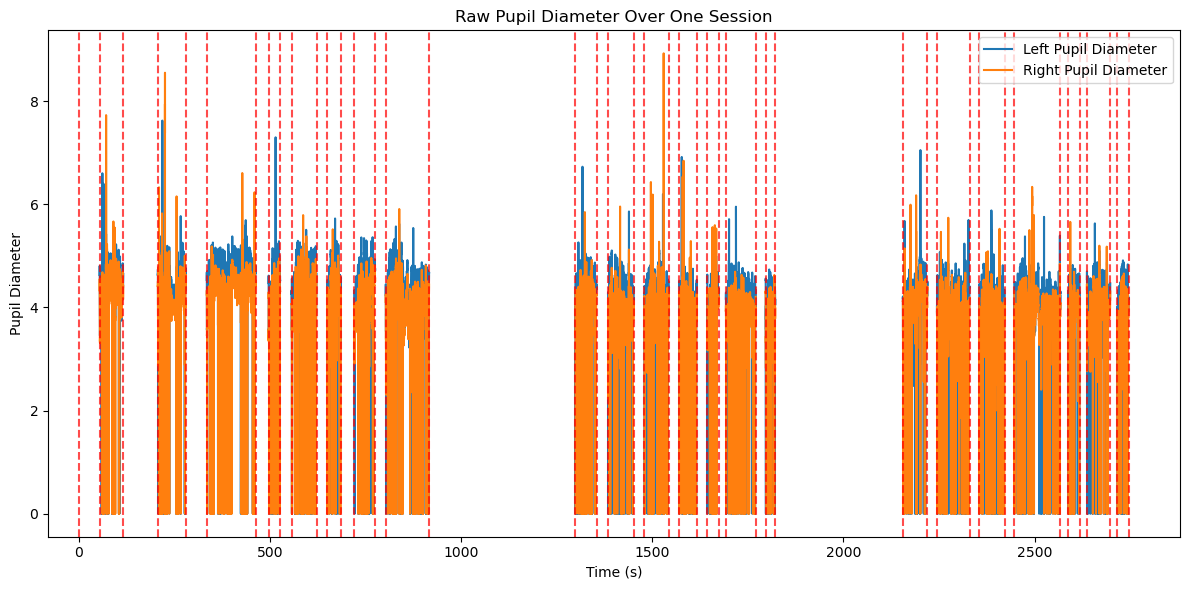

In [ ]:
# Create a mask for is_building_model == True
mask_true = relevant_df['is_building_model'] == True

# Plotting left and right pupil diameters only where is_building_model is True
plt.figure(figsize=(12, 6))

# Plot pupil diameter with NaNs where is_building_model is False
left_pupil = relevant_df['left_pupil_diameter'].where(mask_true)
right_pupil = relevant_df['right_pupil_diameter'].where(mask_true)

# Use gaze_capture_time as x-axis (assuming it is numeric or datetime)
plt.plot(relevant_df['time'], left_pupil, label='Left Pupil Diameter')
plt.plot(relevant_df['time'], right_pupil, label='Right Pupil Diameter')

# Identify indices where is_building_model changes value (True <-> False)
diff = relevant_df['is_building_model'].astype(int).diff()
change_points = relevant_df.index[(diff != 0).fillna(False)]

# Draw vertical lines at these points to indicate periods where is_building_model changes
for idx in change_points:
    x_val = relevant_df.loc[idx, 'time']
    plt.axvline(x=x_val, color='red', linestyle='--', alpha=0.7)

plt.xlabel('Time (s)')
plt.ylabel('Pupil Diameter')
plt.title('Raw Pupil Diameter Over One Session')
plt.legend()
plt.tight_layout()
plt.show()

Alternative indicating trial phases:

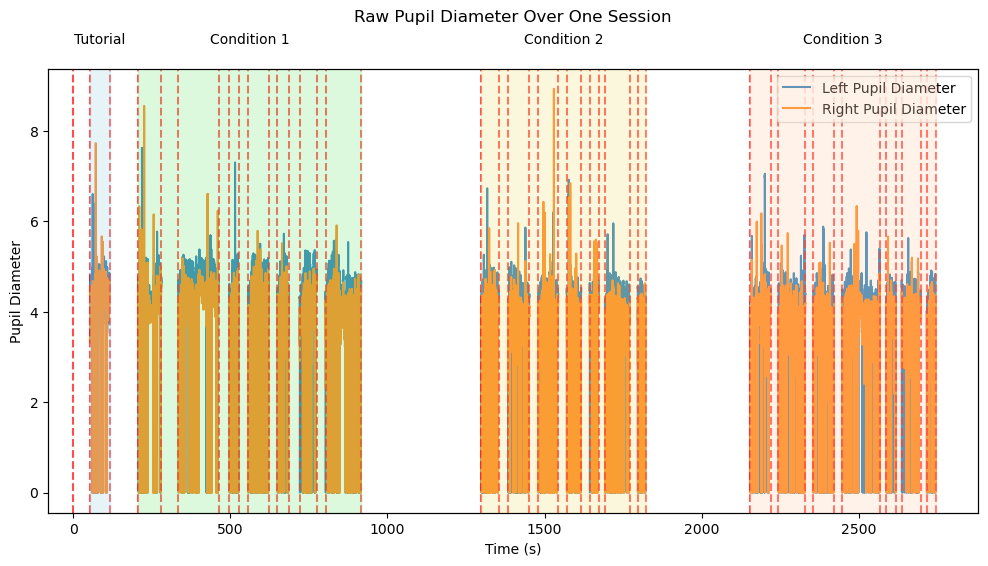

In [ ]:
mask_true = relevant_df['is_building_model'] == True

# Create spans: List of (start_time, end_time) tuples for each building/model period

# Convert mask to int (False=0, True=1), then difference along index
diff = mask_true.astype(int).diff()

# Indices of start points (where diff == 1)
start_indices = diff[diff == 1].index.tolist()

# Indices of end points (where diff == -1)
end_indices = diff[diff == -1].index.tolist()

# If building period starts at the first row
if mask_true.iloc[0]:
    start_indices = [mask_true.index[0]] + start_indices

# If building period ends at the last row
if mask_true.iloc[-1]:
    end_indices = end_indices + [mask_true.index[-1]]
    
spans = []
for start_idx, end_idx in zip(start_indices, end_indices):
    start_time = relevant_df.loc[start_idx, 'time']
    end_time = relevant_df.loc[end_idx, 'time']
    spans.append((start_time, end_time))
    
# Corresponding period names for each span (adjust as needed)
period_names = ['Tutorial'] + ['Condition 1']*7 + ['Condition 2']*7 + ['Condition 3']*7

# Calculate midpoints of each period for label positioning
midpoints = [(start + end) / 2 for start, end in spans]
    
# Plot
left_pupil = relevant_df['left_pupil_diameter'].where(mask_true)
right_pupil = relevant_df['right_pupil_diameter'].where(mask_true)

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting pupil diameter with NaNs (gaps)
left_pupil = relevant_df['left_pupil_diameter'].where(mask_true)
right_pupil = relevant_df['right_pupil_diameter'].where(mask_true)
ax.plot(relevant_df['time'], left_pupil, label='Left Pupil Diameter')
ax.plot(relevant_df['time'], right_pupil, label='Right Pupil Diameter')

# Vertical lines at change points
diff = relevant_df['is_building_model'].astype(int).diff()
change_points = relevant_df.index[(diff != 0).fillna(False)]
for idx in change_points:
    x_val = relevant_df.loc[idx, 'time']
    ax.axvline(x=x_val, color='red', linestyle='--', alpha=0.7)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil Diameter')
ax.set_title('Raw Pupil Diameter Over One Session')
ax.legend(loc='upper right')

# Adding second x-axis for period labels

# Group spans by condition label and get min/max of each group for wider grouping
grouped_spans = OrderedDict()
for span, label in zip(spans, period_names):
    if label not in grouped_spans:
        grouped_spans[label] = [span[0], span[1]]
    else:
        grouped_spans[label][0] = min(grouped_spans[label][0], span[0])
        grouped_spans[label][1] = max(grouped_spans[label][1], span[1])

# Create second x-axis on top
ax2 = ax.twiny()

# Set limits same as original axis
ax2.set_xlim(ax.get_xlim())

# Remove default ticks
ax2.set_xticks([])

# Plot colored bars on the top axis for each grouped period to visually separate them

# Define colors for each phase
phase_colors = {
    'Tutorial': 'lightblue',
    'Condition 1': 'lightgreen',
    'Condition 2': 'khaki',
    'Condition 3': 'peachpuff'
}

# Plot colored bars on the top axis for each grouped period with different colors
for label, (start, end) in grouped_spans.items():
    color = phase_colors.get(label, 'lightgray')  # fallback color if label not found
    ax2.axvspan(start, end, color=color, alpha=0.3)

# Add centered text labels above the plot for each trial phase group
for label, (start, end) in grouped_spans.items():
    ax2.text((start + end) / 2, 1.05, label, ha='center', va='bottom', transform=ax2.get_xaxis_transform(), fontsize=10)

# Increase top margin to make space for labels
plt.subplots_adjust(top=0.85)

# Label for second axis, placed above the text labels
ax2.set_xlabel(' ', labelpad=20)

plt.show()

Plot cleaned pupil diameter for the all building periods:

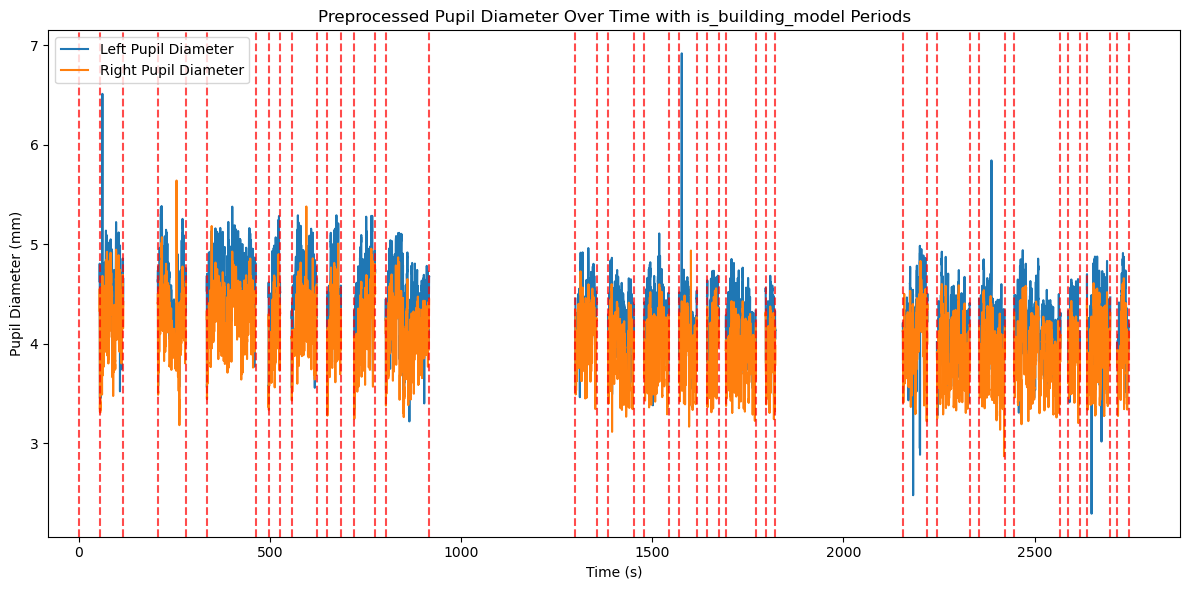

In [ ]:
# Copy relevant data
clean_df = relevant_df.copy()

buffer_samples = 30  # adjust as needed (10-30, ~50-150 ms)

# Define combined buffer function (blinks + outliers)
def add_combined_buffer(df, blink_col='blink', lower=2, upper=8, buffer=30):
    blink_mask = df[blink_col].values
    
    # Define outliers outside physiological pupil diameter range
    outlier_mask = ((df['left_pupil_diameter'] < lower) | (df['left_pupil_diameter'] > upper) |
                    (df['right_pupil_diameter'] < lower) | (df['right_pupil_diameter'] > upper)).values
    
    combined_mask = blink_mask | outlier_mask
    
    expanded_mask = np.zeros(len(combined_mask), dtype=bool)
    indices = np.where(combined_mask)[0]
    
    for idx in indices:
        start = max(0, idx - buffer)
        end = min(len(combined_mask), idx + buffer + 1)
        expanded_mask[start:end] = True
    
    return expanded_mask

# Apply combined buffering to mark blink and outlier regions as NaN
buffer_mask = add_combined_buffer(clean_df, blink_col='blink', lower=2, upper=8, buffer=buffer_samples)

clean_df.loc[buffer_mask, 'left_pupil_diameter'] = np.nan
clean_df.loc[buffer_mask, 'right_pupil_diameter'] = np.nan

# Interpolate missing data with linear interpolation
clean_df['left_pupil_diameter'] = clean_df['left_pupil_diameter'].interpolate(method='linear', limit_direction='both')
clean_df['right_pupil_diameter'] = clean_df['right_pupil_diameter'].interpolate(method='linear', limit_direction='both')

# Plot preparation
mask_true = clean_df['is_building_model'] == True

plt.figure(figsize=(12, 6))

# Left and right pupil diameters masked to show only when is_building_model is True
left_pupil = clean_df['left_pupil_diameter'].where(mask_true)
right_pupil = clean_df['right_pupil_diameter'].where(mask_true)

plt.plot(clean_df['time'], left_pupil, label='Left Pupil Diameter')
plt.plot(clean_df['time'], right_pupil, label='Right Pupil Diameter')

# Draw vertical lines to indicate when is_building_model changes
diff = clean_df['is_building_model'].astype(int).diff()
change_points = clean_df.index[(diff != 0).fillna(False)]

for idx in change_points:
    x_val = clean_df.loc[idx, 'time']
    plt.axvline(x=x_val, color='red', linestyle='--', alpha=0.7)

plt.xlabel('Time (s)')
plt.ylabel('Pupil Diameter (mm)')
plt.title('Preprocessed Pupil Diameter Over Time with is_building_model Periods')
plt.legend()
plt.tight_layout()
plt.show()

Plot mean pupil diameter for all building periods:

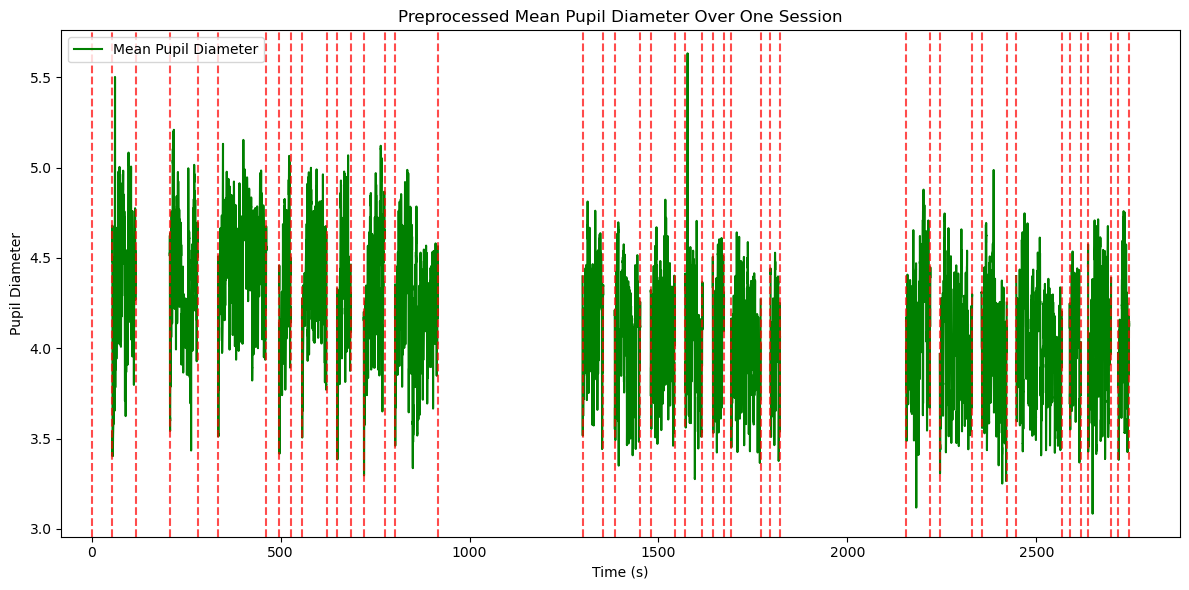

In [ ]:
clean_df['mean_pupil_diameter'] = clean_df[['left_pupil_diameter', 'right_pupil_diameter']].mean(axis=1)

# Create a mask for is_building_model == True
mask_true = clean_df['is_building_model'] == True

# Plotting left and right pupil diameters only where is_building_model is True
plt.figure(figsize=(12, 6))

# Plot pupil diameter with NaNs where is_building_model is False
mean_pupil = clean_df['mean_pupil_diameter'].where(mask_true)

# Use gaze_capture_time as x-axis (assuming it is numeric or datetime)
plt.plot(clean_df['time'], mean_pupil, color='green', label='Mean Pupil Diameter')

# Identify indices where is_building_model changes value (True <-> False)
diff = clean_df['is_building_model'].astype(int).diff()
change_points = clean_df.index[(diff != 0).fillna(False)]

# Draw vertical lines at these points to indicate periods where is_building_model changes
for idx in change_points:
    x_val = clean_df.loc[idx, 'time']
    plt.axvline(x=x_val, color='red', linestyle='--', alpha=0.7)

plt.xlabel('Time (s)')
plt.ylabel('Pupil Diameter')
plt.title('Preprocessed Mean Pupil Diameter Over One Session')
plt.legend()
plt.tight_layout()
plt.show()

Alternative indicating trial phases:

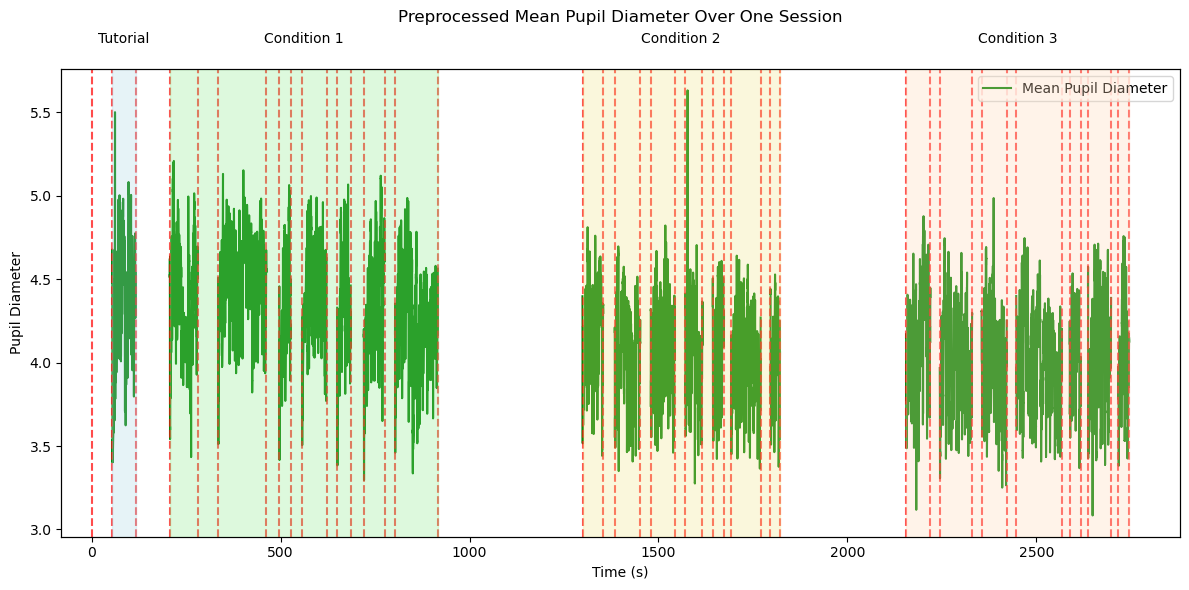

In [17]:
# Calculate mean pupil diameter
clean_df['mean_pupil_diameter'] = clean_df[['left_pupil_diameter', 'right_pupil_diameter']].mean(axis=1)

# Create mask for building model periods
mask_true = clean_df['is_building_model'] == True

# Reuse the same span extraction as before from relevant_df or re-calc here:
diff = mask_true.astype(int).diff()

start_indices = diff[diff == 1].index.tolist()
end_indices = diff[diff == -1].index.tolist()

if mask_true.iloc[0]:
    start_indices = [mask_true.index[0]] + start_indices

if mask_true.iloc[-1]:
    end_indices = end_indices + [mask_true.index[-1]]

spans = []
for start_idx, end_idx in zip(start_indices, end_indices):
    start_time = clean_df.loc[start_idx, 'time']
    end_time = clean_df.loc[end_idx, 'time']
    spans.append((start_time, end_time))

# Define period names for all spans (make sure length matches spans length)
period_names = ['Tutorial'] + ['Condition 1']*7 + ['Condition 2']*7 + ['Condition 3']*7

grouped_spans = OrderedDict()
for span, label in zip(spans, period_names):
    if label not in grouped_spans:
        grouped_spans[label] = [span[0], span[1]]
    else:
        grouped_spans[label][0] = min(grouped_spans[label][0], span[0])
        grouped_spans[label][1] = max(grouped_spans[label][1], span[1])

# Plot
fig, ax = plt.subplots(figsize=(12,6))

# Plot mean pupil diameter with NaNs outside building periods to create gaps
mean_pupil = clean_df['mean_pupil_diameter'].where(mask_true)
ax.plot(clean_df['time'], mean_pupil, color='green', label='Mean Pupil Diameter')

# Vertical red dashed lines at change points in building model flag
diff_build = clean_df['is_building_model'].astype(int).diff()
change_points = clean_df.index[(diff_build != 0).fillna(False)]
for idx in change_points:
    x_val = clean_df.loc[idx, 'time']
    ax.axvline(x=x_val, color='red', linestyle='--', alpha=0.7)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil Diameter')
ax.set_title('Preprocessed Mean Pupil Diameter Over One Session')
ax.legend(loc='upper right')

# Create second x-axis on top with grouped period visualization
phase_colors = {
    'Tutorial': 'lightblue',
    'Condition 1': 'lightgreen',
    'Condition 2': 'khaki',
    'Condition 3': 'peachpuff',
}

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([])  # remove ticks

for label, (start, end) in grouped_spans.items():
    color = phase_colors.get(label, 'lightgray')
    ax2.axvspan(start, end, color=color, alpha=0.3)
    ax2.text((start + end)/2, 1.05, label, ha='center', va='bottom',
             transform=ax2.get_xaxis_transform(), fontsize=10)

# Add margin on top for labels
plt.subplots_adjust(top=0.85)
ax2.set_xlabel(' ', labelpad=20)

plt.tight_layout()
plt.show()